<a href="https://colab.research.google.com/github/Itsmrk/Deep_learning/blob/master/12_Flowers_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# **Download the Flowers Dataset using TensorFlow Datasets**

In [0]:
(traning_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]','train[70%:]' ],
    with_info = True,
    as_supervised = True,
)

## **Print Information about the Flowers Dataset**

In [5]:
num_classes = dataset_info.features['label'].num_classes
print('Total Number of classes: {}'.format(num_classes))
num_traning_examples = 0
num_validation_examples = 0

for example in traning_set:
  num_traning_examples += 1
print('Total Number of Training Images: {}'.format(num_traning_examples))

for examples in validation_set:
  num_validation_examples += 1
print('Total Number of Validating Images: {}'.format(num_validation_examples))


Total Number of classes: 5
Total Number of Training Images: 2569
Total Number of Validating Images: 1101


The images in the Flowers dataset are not all the same size.

In [6]:
for i, examples in enumerate(traning_set.take(5)):
  print('image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

image 1 shape: (283, 500, 3) label: 0
image 2 shape: (283, 500, 3) label: 0
image 3 shape: (283, 500, 3) label: 0
image 4 shape: (283, 500, 3) label: 0
image 5 shape: (283, 500, 3) label: 0


# **Reformat Images and Create Batches**

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE =32

train_batches = traning_set.shuffle(num_traning_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## **Simple Transfer Learning with TensorFlow Hub**

### **Create a Feature Extractor**

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES, IMAGE_RES , 3))

### **Freeze the Pre-Trained Model**

In [0]:
feature_extractor.trainable = False

### **Attach a classification head**

In [10]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes)
                             ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### **Train the model**

In [11]:
model.compile(
    optimizer = 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 9s 105ms/step - loss: 0.7674 - accuracy: 0.7190 - val_loss: 0.4843 - val_accuracy: 0.8347
Epoch 2/6
81/81 [==============================] - 8s 96ms/step - loss: 0.3872 - accuracy: 0.8743 - val_loss: 0.3640 - val_accuracy: 0.8856
Epoch 3/6
81/81 [==============================] - 8s 96ms/step - loss: 0.2991 - accuracy: 0.9097 - val_loss: 0.3300 - val_accuracy: 0.8974
Epoch 4/6
81/81 [==============================] - 8s 96ms/step - loss: 0.2496 - accuracy: 0.9280 - val_loss: 0.3065 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 8s 97ms/step - loss: 0.2151 - accuracy: 0.9381 - val_loss: 0.2943 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 8s 96ms/step - loss: 0.1844 - accuracy: 0.9510 - val_loss: 0.3027 - val_accuracy: 0.8928


# **Plot Training and Validation Graphs**

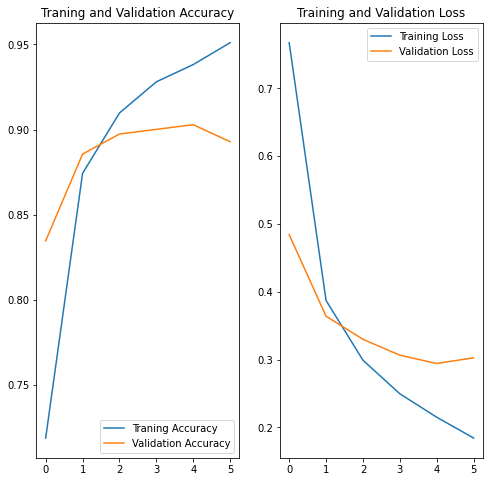

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Traning Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Traning and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Check Predictions**

In [13]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### **Create an Image Batch and Make Predictions**

In [14]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'dandelion' 'dandelion' 'roses' 'dandelion' 'daisy' 'dandelion'
 'daisy' 'sunflowers' 'sunflowers' 'dandelion' 'tulips' 'dandelion'
 'sunflowers' 'roses' 'dandelion' 'dandelion' 'dandelion' 'sunflowers'
 'dandelion' 'daisy' 'tulips' 'sunflowers' 'roses' 'daisy' 'dandelion'
 'roses' 'daisy' 'daisy' 'tulips' 'daisy' 'sunflowers']


## **Print True Labels and Predicted Indices**

In [15]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 0 0 4 0 1 0 1 3 3 0 2 0 3 4 0 0 0 3 0 1 2 3 4 1 0 4 1 1 2 1 3]
Predicted labels:  [2 0 0 4 0 1 0 1 3 3 0 2 0 3 4 0 0 0 3 0 1 2 3 4 1 0 4 1 1 2 1 3]


## **Plot Model Predictions**

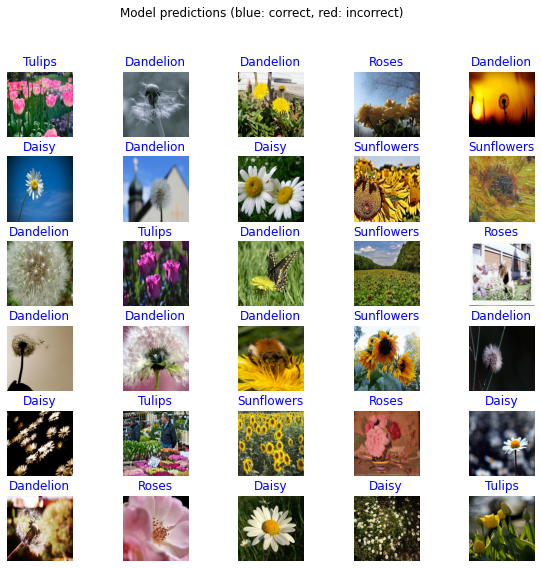

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## **Perform Transfer Learning with the Inception Model**

In [18]:
"""IMAGE_RES = 224

(traning_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info= True,
    as_supervised = True,
    split = ['train[:70%]','train[70%:]'],
)
train_batches = training_set.shuffle(num_traning_examples//4).map(format_image).batch(BATCH_SIZE).perfect(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).perfect(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.kerasLayers(URL,
                                    input_shape =(IMAGE_RES, IMAGE_RES, 3),
                                    trainable = False)
model_inception = tf.keras.Sequential([
                                       feature_extractor,
                                       tf.kerasLayers.Dense(num_classes)
])

model_inception.summary()"""

IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_traning_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
model_inception.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 12s 146ms/step - loss: 0.7375 - accuracy: 0.7306 - val_loss: 0.4309 - val_accuracy: 0.8683
Epoch 2/6
81/81 [==============================] - 10s 129ms/step - loss: 0.3820 - accuracy: 0.8817 - val_loss: 0.3520 - val_accuracy: 0.8883
Epoch 3/6
81/81 [==============================] - 10s 128ms/step - loss: 0.3047 - accuracy: 0.9062 - val_loss: 0.3223 - val_accuracy: 0.8874
Epoch 4/6
81/81 [==============================] - 10s 129ms/step - loss: 0.2581 - accuracy: 0.9210 - val_loss: 0.2976 - val_accuracy: 0.8946
Epoch 5/6
81/81 [==============================] - 10s 127ms/step - loss: 0.2305 - accuracy: 0.9307 - val_loss: 0.2797 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 11s 130ms/step - loss: 0.2040 - accuracy: 0.9447 - val_loss: 0.2709 - val_accuracy: 0.9055
